In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
test_df = pd.read_csv('test.csv')

### EDA

In [4]:
train_df = pd.read_csv('train.csv')

In [5]:
train_df.head()

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,target
0,-6536978109522202983,0,0.000000,0.0,0.000000,0.011364,0.006579,0.0311,0.013158,0.006579,0.228694,0.0,0.333073,0.0,0.0,0.019737,0.064203,0.263279,0.011364,0.000000,0.0,0.00000,0.01087,0.0,86.0,24137.0,0.666667,5.205102,77.950000,21.400000,132.666667,0.000000,0.000000,0.166667,0.000000,4.82,0.000000,2440.153846,301.566667,0.500000,12.076923,11038.166667,15.400000,4.82,8.911111,200.0,0.000000,4.820000,0.333333,6712.0,0.333333,0.0
1,-6536978109522202983,1,0.000000,0.0,0.000000,0.011364,0.006579,0.0311,0.013158,0.006579,0.228694,0.0,0.333073,0.0,0.0,0.019737,0.064203,0.263279,0.011364,0.000000,0.0,0.00000,0.01087,0.0,64.0,43316.0,0.347826,3.926019,105.650000,10.800000,154.608696,0.000000,0.000000,0.130435,0.130435,4.82,0.130435,1761.000000,487.050000,0.217391,10.518868,14078.000000,17.016667,4.82,8.292754,510.0,0.000000,4.820000,0.652174,4873.0,0.391304,0.0
2,-6536978109522202983,2,0.000000,0.0,0.000000,0.011364,0.006579,0.0311,0.013158,0.006579,0.228694,0.0,0.333073,0.0,0.0,0.019737,0.064203,0.263279,0.011364,0.000000,0.0,0.00000,0.01087,0.0,59.0,19961.0,0.500000,3.627770,38.100000,11.766667,122.318182,0.000000,0.000000,0.181818,0.227273,4.82,0.181818,1560.333333,92.733333,0.227273,7.974747,10814.454545,41.100000,4.82,9.753030,190.0,0.000000,4.820000,0.500000,2175.0,0.181818,0.0
3,-6536978109522202983,3,0.000000,0.0,0.000000,0.011364,0.006579,0.0311,0.013158,0.006579,0.228694,0.0,0.333073,0.0,0.0,0.019737,0.064203,0.263279,0.011364,0.000000,0.0,0.00000,0.01087,0.0,67.0,40729.0,0.473684,3.348995,86.983333,15.366667,152.368421,0.026316,0.026316,0.105263,0.105263,4.78,0.131579,2028.533333,487.016667,0.263158,17.708333,13842.052632,33.850000,4.82,10.520614,382.0,0.026316,4.814737,0.447368,4093.0,0.394737,0.0
4,-1744017237843019509,0,0.051282,1.0,0.014363,0.018308,0.037632,0.0000,0.180246,0.103449,0.379082,0.0,0.020292,0.0,0.0,0.000000,0.000000,0.055489,0.071362,0.071817,0.0,0.04796,0.00000,0.0,47.0,56986.0,0.304348,3.916232,30.466667,5.200000,143.217391,0.000000,0.000000,0.152174,0.152174,4.86,0.347826,1960.274510,105.433333,0.108696,10.819113,10859.086957,31.866667,4.94,9.438406,777.0,0.021739,4.908478,0.673913,1296.0,0.239130,0.0


#### Same target for the same Id

In [6]:
train_df.groupby(['Id'])['target'].mean().value_counts()

0.0    6379
1.0    1336
Name: target, dtype: int64

In [7]:
X = train_df.drop(['target'], axis=1).copy()
y = train_df[['Id', 'target']].drop_duplicates(keep='first')['target'].copy()

#### Explore target variable

In [8]:
y.value_counts(normalize=True)

0.0    0.826831
1.0    0.173169
Name: target, dtype: float64

#### Explore numerical data

In [9]:
X['P20'].value_counts()

4.99    3946
4.98    3409
5.00    3286
4.97    2567
4.96    2489
        ... 
4.50       1
4.44       1
4.42       1
4.48       1
4.26       1
Name: P20, Length: 63, dtype: int64

In [10]:
# for col in X.columns.drop(columns_to_drop):
#     print(f'{col}: {X[col].nunique()}')

#### V1 - V22 columns if same for the same Id

In [11]:
X['Week'].value_counts()

0    7715
1    7715
2    7715
3    7715
Name: Week, dtype: int64

In [12]:
X.columns

Index(['Id', 'Week', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8',
       'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18',
       'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27'],
      dtype='object')

In [13]:
X_selected = X[['Id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22']].copy()

In [14]:
X_selected.shape

(30860, 23)

In [15]:
X_selected.drop_duplicates(keep='first').shape[0] * 4

30860

##### Conclusion: Columns V1 - V22 duplicates for the same Id

#### V1 - V22 columns correlation

In [16]:
columns_to_drop = []

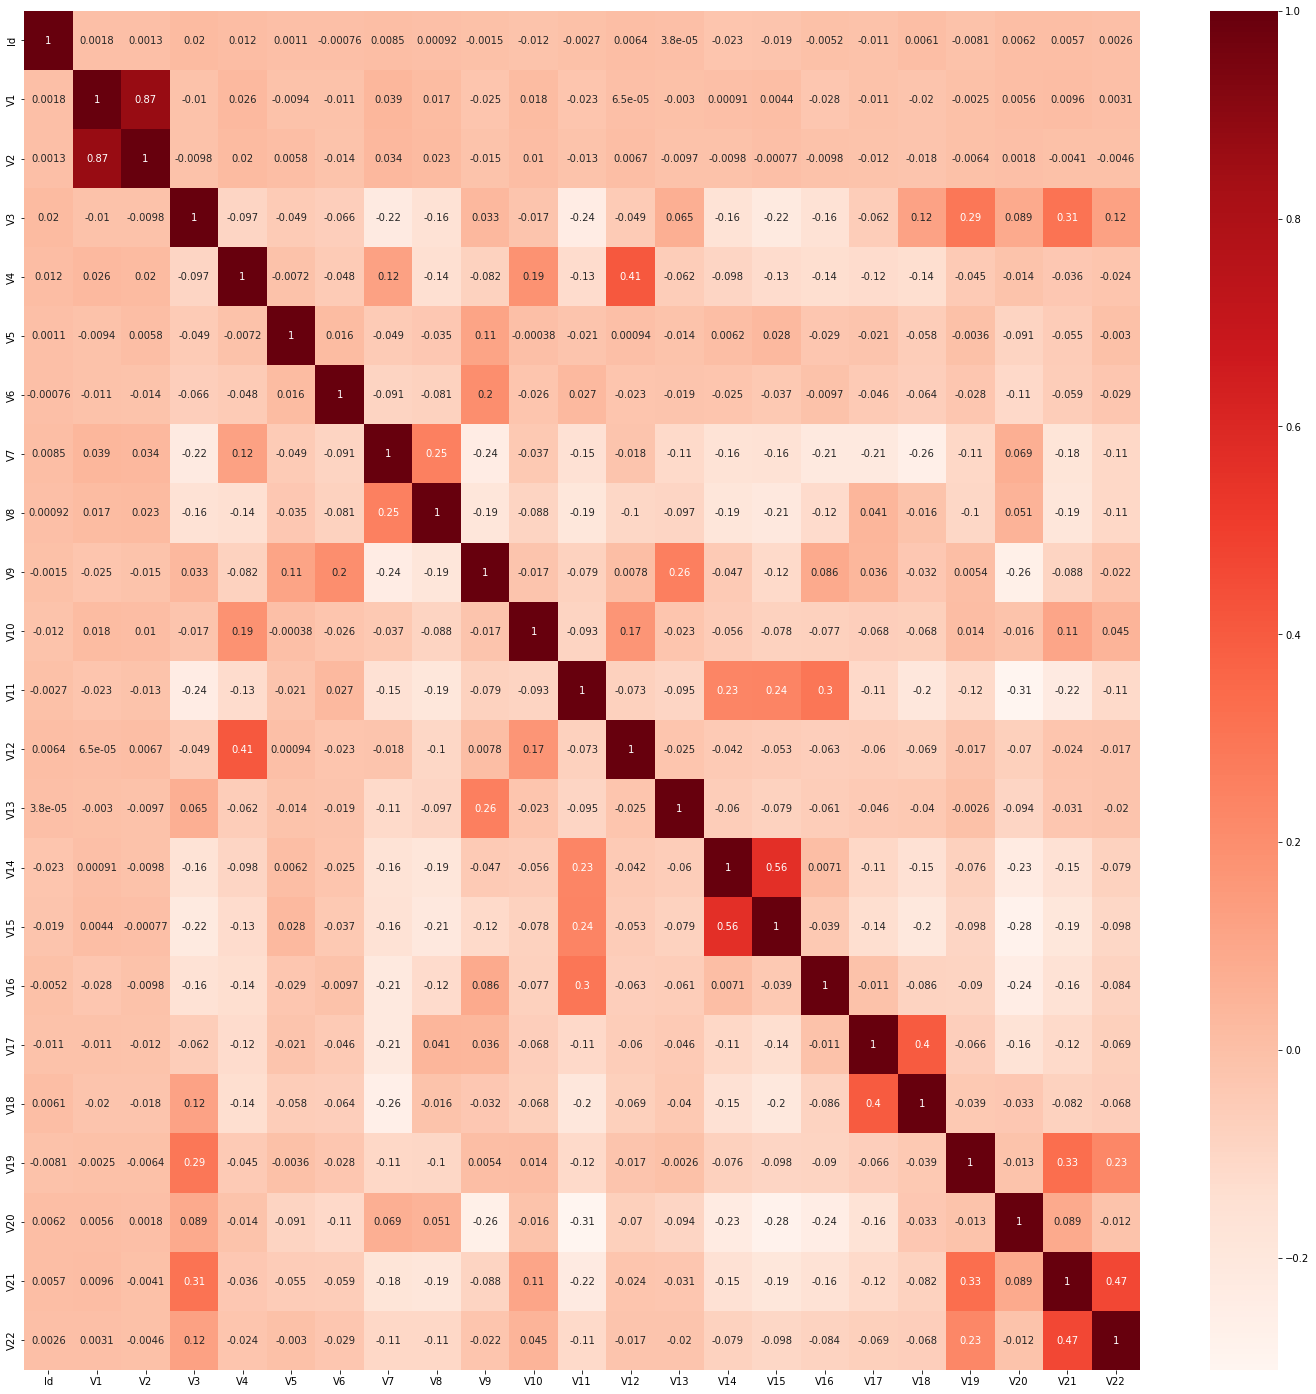

In [17]:
#Using Pearson Correlation
plt.figure(figsize=(25, 25))
cor = X_selected.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
corr_threshold = 0.75

cor[(abs(cor) > corr_threshold) & (cor != 1)].dropna(how='all')

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
V1,NaN,NaN,0.870245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V2,NaN,0.870245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
pd.concat([X_selected, y], axis=1).corr()['target'][['V1', 'V2']].sort_values()

V2    0.061291
V1    0.102470
Name: target, dtype: float64

In [20]:
columns_to_drop.append('V2')

#### P1 - P27 columns correlation

In [21]:
X_selected = X[['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8',
       'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18',
       'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27']].copy()

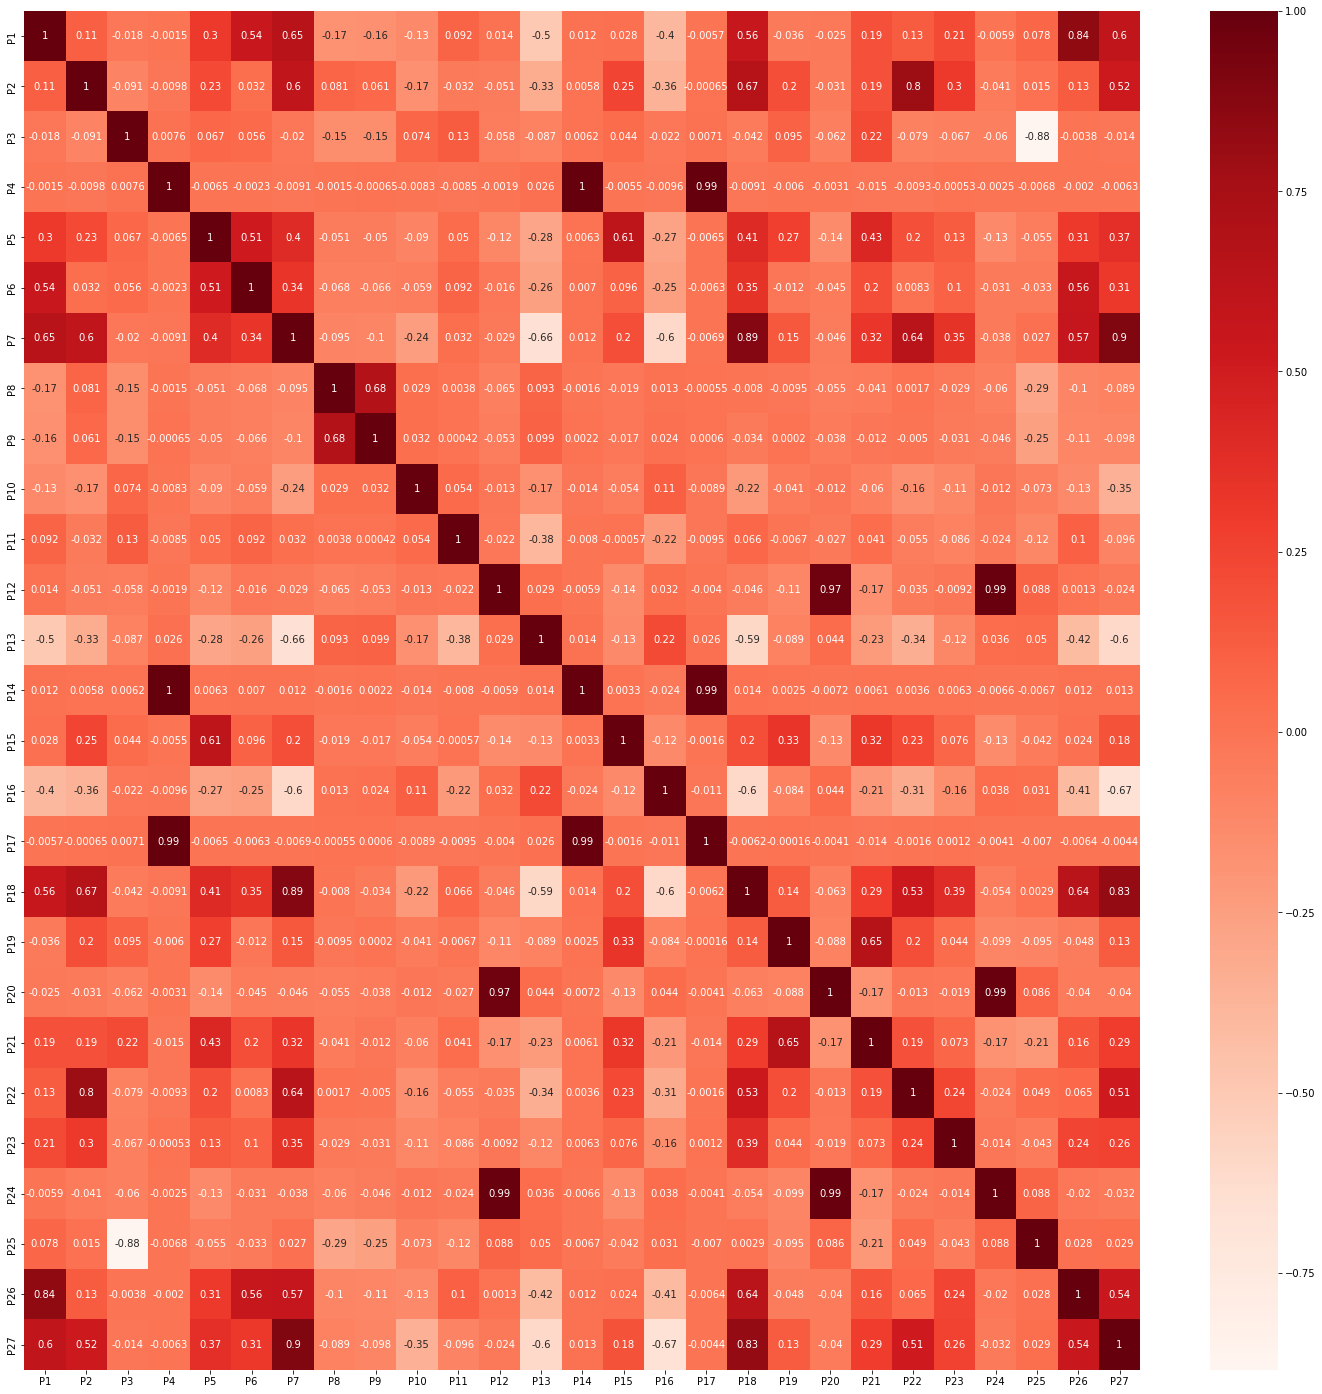

In [22]:
#Using Pearson Correlation
plt.figure(figsize=(25, 25))
cor = X_selected.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [23]:
corr_threshold = 0.75

cor[(abs(cor) > corr_threshold) & (cor != 1)].dropna(how='all', axis=0).dropna(how='all', axis=1)

,P1,P2,P3,P4,P7,P12,P14,P17,P18,P20,P22,P24,P25,P26,P27
P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.843094,NaN
P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80014,NaN,NaN,NaN,NaN
P3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.884264,NaN,NaN
P4,NaN,NaN,NaN,NaN,NaN,NaN,0.998896,0.993813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.889168,NaN,NaN,NaN,NaN,NaN,0.899187
P12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967439,NaN,0.989080,NaN,NaN,NaN
P14,NaN,NaN,NaN,0.998896,NaN,NaN,NaN,0.992500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P17,NaN,NaN,NaN,0.993813,NaN,NaN,0.992500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P18,NaN,NaN,NaN,NaN,0.889168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.826998
P20,NaN,NaN,NaN,NaN,NaN,0.967439,NaN,NaN,NaN,NaN,NaN,0.990029,NaN,NaN,NaN


In [24]:
pd.concat([X_selected, y], axis=1).corr()['target'][['P1', 'P2', 'P3', 'P4', 'P7', 'P12', 'P14', 'P17', 'P18', 'P20', 'P22',
       'P24', 'P25', 'P26', 'P27']].sort_values()

P2    -0.165848
P22   -0.159937
P17   -0.114789
P25   -0.050586
P20   -0.030093
P4    -0.023716
P24   -0.008734
P12    0.013229
P14    0.031716
P3     0.058324
P27    0.077578
P7     0.082974
P18    0.085083
P1     0.320356
P26    0.344295
Name: target, dtype: float64

In [25]:
for col in ['P22', 'P1', 'P25', 'P17', 'P4', 'P18', 'P24', 'P12']:
    columns_to_drop.append(col)

#### Plot distibution for each column

In [26]:
# for col in X.columns.drop(['Id', 'Week']):
#     plt.figure()
#     plt.title(f'{col} distribution')
#     np.log(X[col] + 0.5).plot.hist()
#     plt.show()

#### Normalize X features

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [28]:
scaler = StandardScaler()

In [29]:
X_scaled = X.copy()

In [30]:
X_scaled[X_scaled.columns.drop(['Id', 'Week'])] = scaler.fit_transform(X.drop(['Id', 'Week'], axis=1))

In [31]:
X_scaled = X_scaled.fillna(X_scaled.mean())

In [32]:
fill_na_mean_col_value = X_scaled.mean()

In [33]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [34]:
# imp_mean.fit_transform(X_scaled)

In [35]:
X_week_0 = X_scaled[X_scaled['Week'] == 0].drop(['Week'], axis=1).copy()

X_week_1 = X_scaled[X_scaled['Week'] == 1].drop(['Week', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22'], axis=1).copy()

X_week_2 = X_scaled[X_scaled['Week'] == 2].drop(['Week', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22'], axis=1).copy()

X_week_3 = X_scaled[X_scaled['Week'] == 3].drop(['Week', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22'], axis=1).copy()

In [36]:
X_res = pd.merge(
            pd.merge(
                pd.merge(
                    X_week_0,
                    X_week_1,
                    on='Id',
                    suffixes=[None, '_1']),
                X_week_2,
                on='Id',
                suffixes=[None, '_2']),
            X_week_3,
            on='Id',
            suffixes=[None, '_3'])

In [37]:
X_res.head(1)

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P1_1,P2_1,P3_1,P4_1,P5_1,P6_1,P7_1,P8_1,P9_1,P10_1,P11_1,P12_1,P13_1,P14_1,P15_1,P16_1,P17_1,P18_1,P19_1,P20_1,P21_1,P22_1,P23_1,P24_1,P25_1,P26_1,P27_1,P1_2,P2_2,P3_2,P4_2,P5_2,P6_2,P7_2,P8_2,P9_2,P10_2,P11_2,P12_2,P13_2,P14_2,P15_2,P16_2,P17_2,P18_2,P19_2,P20_2,P21_2,P22_2,P23_2,P24_2,P25_2,P26_2,P27_2,P1_3,P2_3,P3_3,P4_3,P5_3,P6_3,P7_3,P8_3,P9_3,P10_3,P11_3,P12_3,P13_3,P14_3,P15_3,P16_3,P17_3,P18_3,P19_3,P20_3,P21_3,P22_3,P23_3,P24_3,P25_3,P26_3,P27_3
0,-6536978109522202983,-0.736454,-0.647184,-0.616923,-0.438722,-0.114414,0.462965,-1.022299,-0.998094,1.843138,-0.277266,2.301286,-0.227953,-0.180442,-0.015173,-0.114011,2.163367,-0.325644,-0.619861,-0.293824,-1.092035,-0.416486,-0.283299,0.367322,-0.199133,0.685428,0.015233,1.448358,0.619947,-0.36723,-0.341541,-0.259751,0.42403,-1.399396,-1.716692,-0.83255,0.096483,1.473711,2.030986,0.012968,0.019169,-0.444879,-2.067623,-0.035261,-0.841623,-0.218339,-1.904593,-0.482194,1.095734,-0.043169,-0.312387,1.317953,-0.312018,0.00277,2.464517,-0.246427,0.088965,-0.341541,-0.259751,0.054733,-0.344955,-1.716692,-0.136155,0.027437,2.9892,0.108389,0.003374,0.651349,-0.38062,-2.067623,-0.248388,1.276159,-0.218339,-1.904593,0.484611,0.510938,0.182275,-0.466866,-0.529461,0.164036,-0.000136,-0.013516,-0.167418,-0.582385,-0.341541,-0.259751,0.578463,0.437888,-1.716692,0.138183,0.007036,-0.23256,0.175613,-0.012293,-0.027356,0.576654,-2.067623,0.25492,-0.909939,-0.218339,-1.904593,0.023181,-0.347019,-0.6324,-0.219699,1.113318,0.081711,-0.002852,1.779741,0.126822,0.042388,-0.07773,0.13735,-0.20183,-0.548444,-2.31386,-0.130046,0.054636,2.988928,0.419741,0.047645,0.60228,0.288478,-2.067623,0.519479,0.40172,0.434816,-1.988038,-0.136411,0.2629,0.195624


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

In [39]:
# X_train, X_test, y_train, y_test = train_test_split(X_res.drop('Id', axis=1), y, test_size=0.2, random_state=42, stratify=y)

In [40]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [41]:
rus = RandomUnderSampler(random_state=42)
X_res_res, y_res = rus.fit_resample(X_res.drop(['Id'], axis=1), y)

In [42]:
# steps = [('under', RandomUnderSampler()), ('model', xgb.XGBClassifier())]
steps = [('model', xgb.XGBClassifier())]
pipeline = Pipeline(steps=steps)

In [43]:
xgb.XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [44]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline, X_res.drop(['Id'], axis=1), y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [45]:
params = {
    
    # default
    'model__objective': ['reg:logistic'],
    'model__eta': [0.11],
    'model__silent': [0],
    "model__nthread": [-1],
    "model__random_seed": [42],
    "model__eval_metric": ['auc'],
    'model__n_estimators': [135],

    # regularization parameters
    'model__max_leaves': [30],
    'model__max_depth': [5],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.7],

    # lightgbm approach][
    'model__tree_method': ['hist'],
    'model__grow_policy': ['lossguide'],
}

In [46]:
import warnings

In [47]:
warnings.filterwarnings('ignore')

In [48]:
search = GridSearchCV(pipeline, params, verbose=3, scoring='roc_auc', n_jobs=-1, cv=cv)
search.fit(X_res_res, y_res)
print("Best parameter (CV score=%0.3f):", search.best_score_)
print(search.best_params_)

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    7.1s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    7.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.5s finished


[11:41:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "random_seed", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best parameter (CV score=%0.3f): 0.9697865440015063
{'model__colsample_bytree': 0.7, 'model__eta': 0.11, 'model__eval_metric': 'auc', 'model__grow_policy': 'lossguide', 'model__max_depth': 5, 'model__max_leaves': 30, 'model__n_estimators': 135, 'model__nthread': -1, 'model__objective': 'reg:logistic', 'model__random_seed': 42, 'model__silent': 0, 'model__subsample': 0.8, 'model__tree_method': 'hist'}


In [49]:
print("Best parameter (CV score=%0.3f):", search.best_score_)
print(search.best_params_)

Best parameter (CV score=%0.3f): 0.9697865440015063
{'model__colsample_bytree': 0.7, 'model__eta': 0.11, 'model__eval_metric': 'auc', 'model__grow_policy': 'lossguide', 'model__max_depth': 5, 'model__max_leaves': 30, 'model__n_estimators': 135, 'model__nthread': -1, 'model__objective': 'reg:logistic', 'model__random_seed': 42, 'model__silent': 0, 'model__subsample': 0.8, 'model__tree_method': 'hist'}


In [50]:
best_xgb_hist = search.best_estimator_

### xgb orig

In [51]:
orig_params = {
    
    # default
    'model__objective': ['reg:logistic'],
    'model__eta': [0.14],
    'model__silent': [0],
    "model__nthread": [-1],
    "model__random_seed": [42],
    "model__eval_metric": ['auc'],
    'model__n_estimators': [250],
    
    'model__gamma': [0.5],

    # regularization parameters
#     'model__max_leaves': [30],
    'model__max_depth': [4],
    'model__min_child_weight': [5],
    'model__subsample': [1.0],
    'model__colsample_bytree': [0.8],

    # lightgbm approach][
#     'model__tree_method': ['hist'],
#     'model__grow_policy': ['lossguide'],
}

Best parameter (CV score=%0.3f): 0.9725332349586373
{'model__colsample_bytree': 0.8, 'model__gamma': 0.5, 'model__max_depth': 4, 'model__min_child_weight': 5, 'model__subsample': 1.0}

In [52]:
steps = [('model', xgb.XGBClassifier())]
pipeline = Pipeline(steps=steps)

In [53]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [54]:
search = GridSearchCV(pipeline, orig_params, verbose=3, scoring='roc_auc', n_jobs=-1, cv=cv)
search.fit(X_res_res, y_res)
print("Best parameter (CV score=%0.3f):", search.best_score_)
print(search.best_params_)

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    4.9s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    5.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.4s finished


[11:42:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "random_seed", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best parameter (CV score=%0.3f): 0.972527876684973
{'model__colsample_bytree': 0.8, 'model__eta': 0.14, 'model__eval_metric': 'auc', 'model__gamma': 0.5, 'model__max_depth': 4, 'model__min_child_weight': 5, 'model__n_estimators': 250, 'model__nthread': -1, 'model__objective': 'reg:logistic', 'model__random_seed': 42, 'model__silent': 0, 'model__subsample': 1.0}


In [55]:
best_xgb_orig = search.best_estimator_

### lightbm for ensembling

In [56]:
import lightgbm as lgb

In [57]:
lgb.LGBMClassifier().get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [58]:
lgm_params = {
    'model__objective': ['binary'],
    'model__learning_rate': [0.19],
    'model__max_depth': [7],
    'model__n_estimators': [250],
    'model__min_child_samples': [15],
    'model__subsample': [0.9],
    'model__colsample_bytree': [0.7],
    'model__n_jobs': [-1],
    'model__random_state': [42],
}

In [59]:
steps = [('model', lgb.LGBMClassifier())]
pipeline = Pipeline(steps=steps)

In [60]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [61]:
search = GridSearchCV(pipeline, lgm_params, verbose=3, scoring='roc_auc', n_jobs=-1, cv=cv)
search.fit(X_res_res, y_res)
print("Best parameter (CV score=%0.3f):", search.best_score_)
print(search.best_params_)

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    4.3s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    4.6s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.5s finished


Best parameter (CV score=%0.3f): 0.9711821246975296
{'model__colsample_bytree': 0.7, 'model__learning_rate': 0.19, 'model__max_depth': 7, 'model__min_child_samples': 15, 'model__n_estimators': 250, 'model__n_jobs': -1, 'model__objective': 'binary', 'model__random_state': 42, 'model__subsample': 0.9}


In [62]:
best_lgb = search.best_estimator_

#### Test data

In [63]:
test_df[test_df.columns.drop(['Id', 'Week'])] = scaler.transform(test_df.drop(['Id', 'Week'], axis=1))

In [64]:
test_df[test_df.columns.drop(['Id', 'Week'])] = test_df.drop(['Id', 'Week'], axis=1).fillna(fill_na_mean_col_value)


In [65]:
X_test_week_0 = test_df[test_df['Week'] == 0].drop(['Week'], axis=1).copy()

X_test_week_1 = test_df[test_df['Week'] == 1].drop(['Week', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22'], axis=1).copy()

X_test_week_2 = test_df[test_df['Week'] == 2].drop(['Week', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22'], axis=1).copy()

X_test_week_3 = test_df[test_df['Week'] == 3].drop(['Week', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22'], axis=1).copy()

In [66]:
X_test_res = pd.merge(
            pd.merge(
                pd.merge(
                    X_test_week_0,
                    X_test_week_1,
                    on='Id',
                    suffixes=[None, '_1']),
                X_test_week_2,
                on='Id',
                suffixes=[None, '_2']),
            X_test_week_3,
            on='Id',
            suffixes=[None, '_3'])

In [67]:
# pred_id = X_test_res['Id'].copy()

In [133]:
# y_pred = search.predict(X_test_res.drop('Id', axis=1))

### simple ensembling

In [68]:
from sklearn.ensemble import VotingClassifier

In [69]:
vclf = VotingClassifier(
    estimators=[('xgb_hist', best_xgb_hist), ('xgb_orig', best_xgb_orig), ('lgb', best_lgb)],
    voting='soft',
#     weights=[.3, .5, .2]
)

In [70]:
vclf.fit(X_res_res, y_res)

[11:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "random_seed", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "random_seed", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




VotingClassifier(estimators=[('xgb_hist',
                              Pipeline(steps=[('model',
                                               XGBClassifier(base_score=0.5,
                                                             booster='gbtree',
                                                             colsample_bylevel=1,
                                                             colsample_bynode=1,
                                                             colsample_bytree=0.7,
                                                             enable_categorical=False,
                                                             eta=0.11,
                                                             eval_metric='auc',
                                                             gamma=0, gpu_id=-1,
                                                             grow_policy='lossguide',
                                                             importance_type=None,
            

In [90]:
y_pred = vclf.predict(X_test_res.drop('Id', axis=1))

In [93]:
tmp = pd.concat([pred_id, pd.Series(y_pred)], axis=1).rename(columns={0: 'Predicted'})

In [94]:
tmp.Predicted.value_counts(normalize=True)

0.0    0.779559
1.0    0.220441
Name: Predicted, dtype: float64

In [95]:
res_pred_df = pd.concat([pred_id, pd.Series(y_pred)], axis=1).rename(columns={0: 'Predicted'})

In [96]:
res_pred_df = pd.concat([pred_id, pd.Series(y_pred)], axis=1).rename(columns={0: 'Predicted'})

In [97]:
res_pred_df.head()

,Id,Predicted
0,6107424960806386948,0.0
1,-1808613790090531322,0.0
2,-2649749947427248381,1.0
3,4684257435812939224,1.0
4,-7030158396775705152,0.0


In [98]:
res_pred_df.Predicted.value_counts(normalize=True)

0.0    0.779559
1.0    0.220441
Name: Predicted, dtype: float64

In [99]:
res_pred_df.to_csv('xgb_hist_orig_lgb.csv', index=False)